# Import libraries

In [1]:
!pip install py_vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.9 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4323 sha256=bf948d47b685b4006e2258dc37d63df1a94184ff7cf8e23e0805ab1ac687b240
  Stored in directory: /root/.cache/pip/wheels/aa/f3/9d/5996e0385444a8f9825b24b94191ee94054e09b4e8f642d1c2
Successfully built py_vncorenlp


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import seaborn as snn
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

from tqdm import tqdm
import pickle
import re
from sklearn.model_selection import train_test_split
import py_vncorenlp

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data

## Read data

In [4]:
with open('/content/drive/MyDrive/Temporun/data/train.txt', 'r') as f:
    train = [line for line in f.readlines()]

In [5]:
with open('/content/drive/MyDrive/Temporun/data/data_phase_0.txt', 'r') as f:
    test = [line for line in f.readlines()]

In [6]:
test

['qua môn\n',
 'thầy trang bị cho chúng em những kiến thức khá hữu ích sau khi ra trường !\n',
 'đáng lí cô phải có phương pháp thông báo đến sinh viên về lịch học trong thời gian gần buổi học , hơn nữa nên tránh trùng lắp với môn học khác .\n',
 'bình thường\n',
 'dạy nhiều kiến thức ngoài hữu ích .\n',
 'Trước khi học thầy, em đã rất mù mờ môn này và phải học lại, thầy đã cứu rỗi em ...\n',
 'môn học này thật sự rất khó và chương trình học hơi nặng ,  mà thầy lại dạy qua loa\n',
 'đồ án không có giới hạn chủ đề, chấm thi kỳ cục :))\n',
 'dạy máy móc , thiếu thực tế .\n',
 'thầy cực kỳ thiên vị :> \n',
 'dạy chán, không tận tâm, qua loa ... là những thứ thầy không có. Học với thầy vui k muốn về\n',
 'cô dạy rất hay hay và nhiệt tình .\n',
 'cô dạy dễ hiểu , hỗ trợ tốt cho các bạn .\n',
 'cô dạy rất tốt rất vui .\n',
 'so với các thầy cô trước em học thì thấy tâm huyết hơn hản\n',
 'thầy hài hước vui vẻ nhiệt tình .\n',
 'thực hành ném cho cái đề rồi bảo tự mò :>\n',
 'giảng dạy rất tố

## Clean data

In [7]:
train = [re.sub('\t', ' ', item) for item in train]
train = [re.sub('\n', '', item) for item in train]
test = [re.sub('\n', '', item) for item in test]

In [8]:
label = [item.split(' ')[0] for item in train]
encoder = LabelEncoder()
label = encoder.fit_transform(label)
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(label_mapping)

{'negative': 0, 'neutral': 1, 'positive': 2}


In [9]:
_, counts = np.unique(label, return_counts=True)
counts

array([1859,  780, 2361])

In [10]:
train = [re.sub('positive|negative|neutral', '', item) for item in train]

In [11]:
train = [re.sub(r'\s+', ' ', item).strip() for item in train]

In [12]:
train[:10]

['tài liệu được bổ sung nhiều và đầy đủ trên moodle .',
 'giảng viên phải nên cho ví dụ cụ thể những phần quan trọng nên nói kỹ có thể lấy ví dụ minh họa tránh việc lập đi lập lại nhiều lần sẽ tạo cảm giác chán cho sinh viên .',
 'bài tập đa dạng , cụ thể .',
 'slide up đầy đủ trước mỗi buổi học .',
 'nội dung giảng dạy quá nhàm chán , khô khan .',
 'thầy chép bảng nhiều .',
 'thầy tận tình hướng dẫn cách làm , giải quyết những thắc mắc của sinh viên .',
 'Rất ổn.',
 'thầy dạy khás hay , cung cấp nhiều thông tin liên quan đến môn học , đưa ra nhiều hướng giải quyết khi sinh viên gặp vấn đề khó khăn với đồ án !',
 'hy vọng học kỳ sau có thể học được với cô .']

In [13]:
max_sent_length = 0
min_sent_length = 9999
max_i = -1
min_i = -1
for i, sent in enumerate(train):
    if len(sent) > max_sent_length:
        max_sent_length = len(sent)
        max_i = i
    if min_sent_length > len(sent):
        min_sent_length = len(sent)
        min_i = i

print(f'Max length: {max_sent_length}, index={max_i}')
print(f'Max length: {min_sent_length}, index={min_i}')

Max length: 462, index=4443
Max length: 4, index=2058


### Visualize

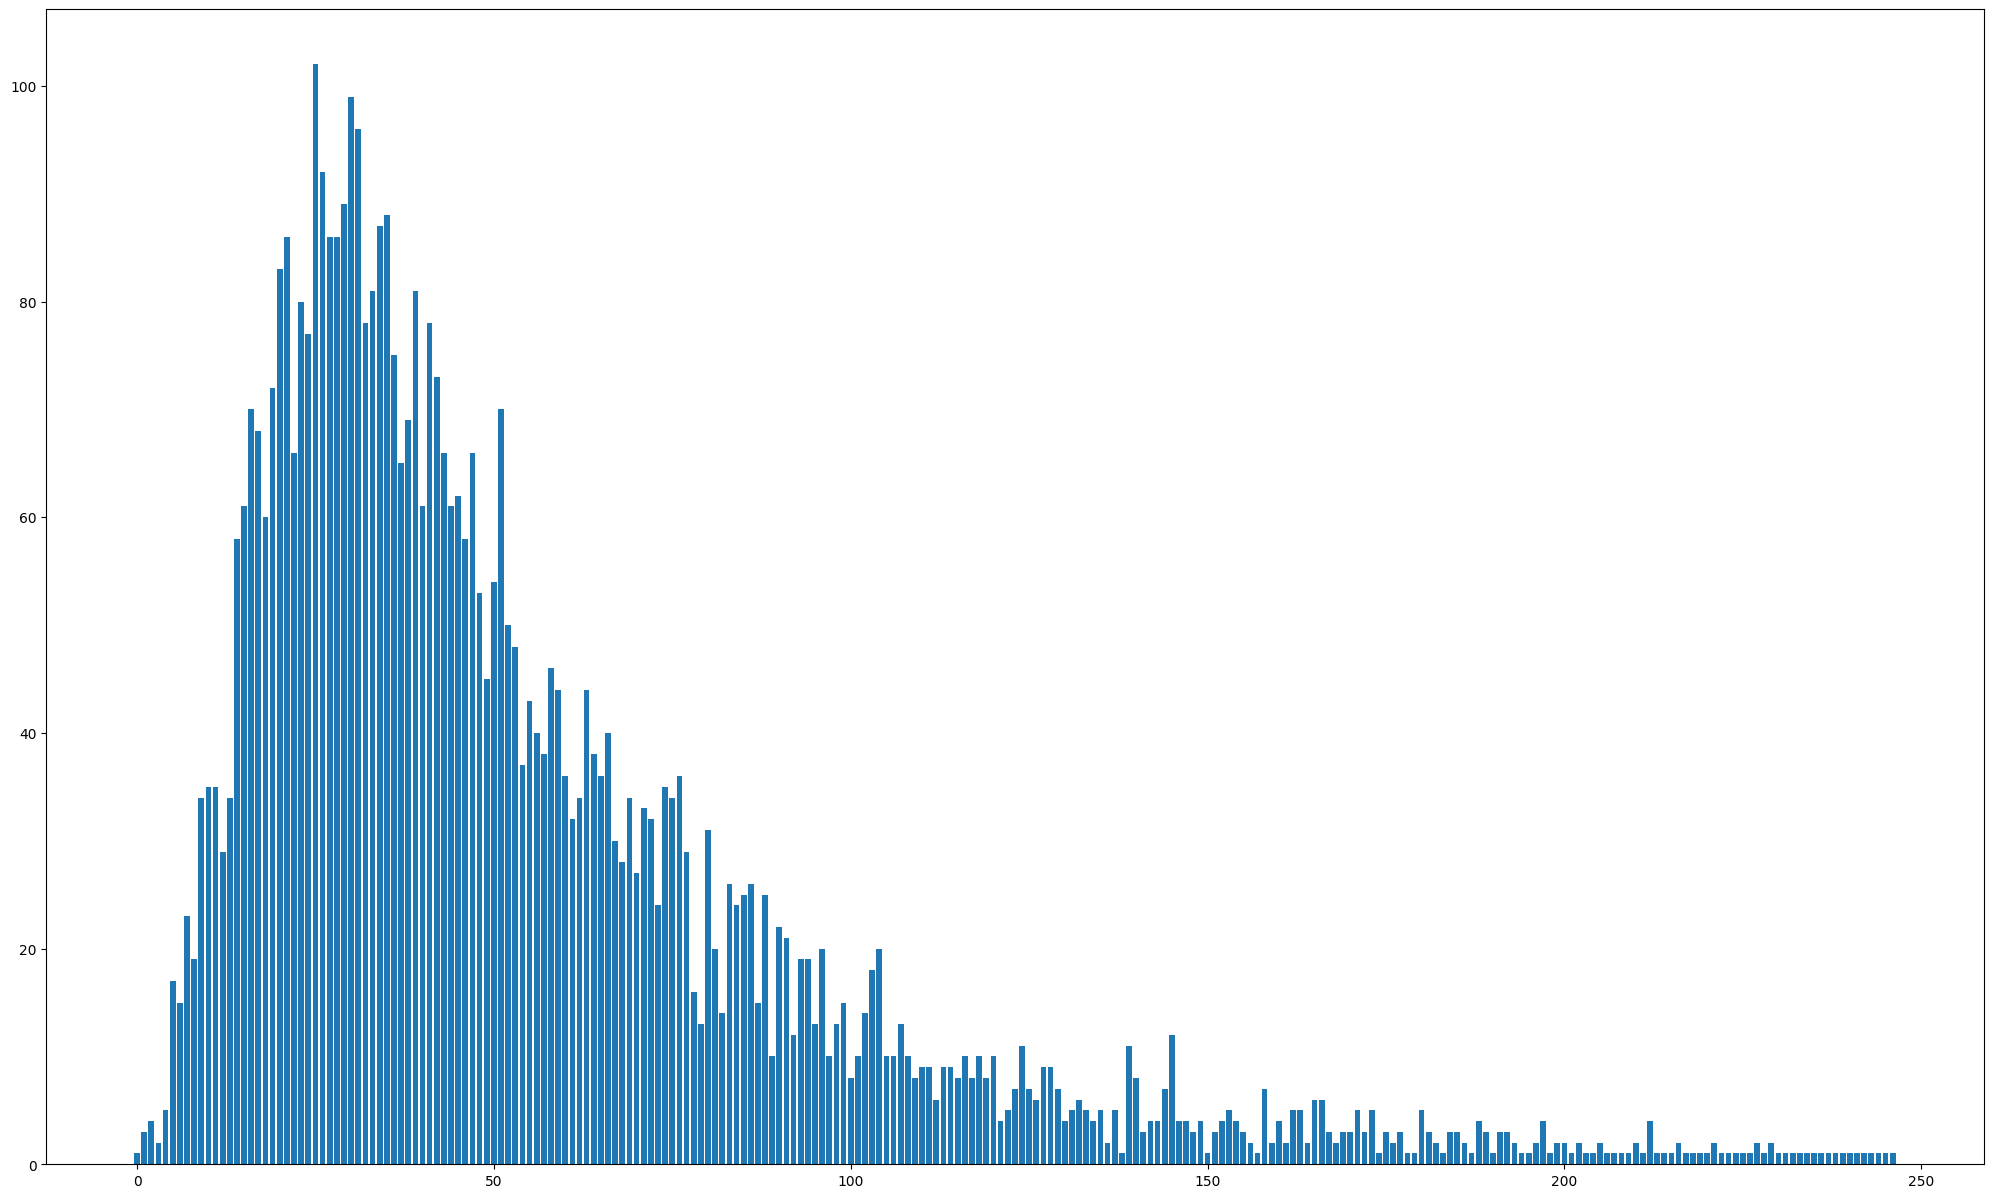

In [14]:
length_sent = [len(i) for i in train]
unique = list(set(length_sent))

counts = [length_sent.count(value) for value in unique]

plt.figure(figsize=(25,15))
plt.bar(range(len(unique)),counts)
plt.show()

# Preprocess

## Add pos neg feature

In [15]:
with open('/content/drive/MyDrive/Temporun/utils/positive_words.txt') as f:
    pos_words = f.readlines()
pos_words = [i.replace("\n","") for i in pos_words]
pos_words.append('hay')

with open('/content/drive/MyDrive/Temporun/utils/negative_words.txt') as f:
    neg_words = f.readlines()
neg_words = [i.replace("\n","") for i in neg_words]
neg_words.append('chưa')

def add_pos_neg_feature(doc):
    doc = word_tokenize(doc)
    for i, token in enumerate(doc):
        if token in pos_words:
            doc[i] = token + '_positive'
        if token in neg_words:
            doc[i] = token + '_negative'
    return ' '.join([w for w in doc])

## Remove stopwords

In [16]:
with open('/content/drive/MyDrive/Temporun/utils/vietnamese-stopwords-dash.txt') as f:
    stopwords = f.readlines()
stopwords = [i.replace("\n","") for i in stopwords]

def remove_stopwords(doc):
    doc = word_tokenize(doc)
    return ' '.join([w for w in doc if w not in stopwords])

## Lower

In [17]:
def lower(doc):
    doc = word_tokenize(doc)
    return ' '.join([w.lower() for w in doc])

## Remove number

In [18]:
def remove_number(doc):
    doc = word_tokenize(doc)
    doc = ' '.join([i for i in doc if not i.isdigit()])
    return doc

## Remove punctuation

In [19]:
def remove_punctuation(doc):
    doc = re.sub(r'[^\w\s]', '', doc)
    doc = re.sub(r'\s+', ' ', doc).strip()
    return doc

## Remove repeated characters

In [20]:
def remove_repeated_characters(doc):
    doc = re.sub(r'([a-z])\1+', lambda m: m.group(1), doc, flags=re.IGNORECASE)
    return doc

## Replace

In [21]:
replace_list = pickle.load(open('/content/drive/MyDrive/Temporun/utils/replace_list.pkl','rb'))
def replace_words(doc):
    doc = word_tokenize(doc)
    for i, token in enumerate(doc):
        if token in replace_list:
            doc[i] = replace_list[token]
    return ' '.join([w for w in doc])

## Remove extra space

In [22]:
def remove_extra_space(doc):
    doc = re.sub(r'\s+', ' ', doc).strip()
    return doc

## Word segmentation

In [23]:
model = py_vncorenlp.VnCoreNLP(annotators=["wseg", "pos"], save_dir='/content/drive/MyDrive/Temporun/vncorenlp')
def word_segmentation(doc):
    annotated = model.annotate_text(doc)
    new_sent = ''
    for sent, _ in annotated.items():
        for item in annotated[sent]:
            # if item['posTag'].startswith('N') or \
            # item['posTag'].startswith('P') or \
            # item['posTag'].startswith('A') or \
            # item['posTag'].startswith('R') or \
            # item['posTag'].startswith('V'):
            new_sent = new_sent + ' ' + item['wordForm'] 
    return new_sent

## Preprocessing

In [24]:
def preprocessing(item):
    item = remove_repeated_characters(item)

    item = replace_words(item)

    item = remove_number(item)

    item = remove_punctuation(item)

    item = remove_extra_space(item)

    # item = remove_stopwords(item)

    item = word_segmentation(item)
    
    item = lower(item)

    item = add_pos_neg_feature(item)

    return item

In [25]:
train = [preprocessing(item) for item in train]
test = [preprocessing(item) for item in test]

# Model

## BiLSTM

### Tokenize

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=25)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization

In [ ]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 1000


vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',
)

In [ ]:
vectorizer.adapt(X_train)

In [ ]:
X_train = vectorizer(X_train)
X_test = vectorizer(X_test)

In [ ]:
EMBEDDING_SIZE = 300
NUM_EPOCHS = 10

model = tf.keras.Sequential([
    keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=MAX_SEQUENCE_LENGTH),
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.2)),
    keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.2)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3)
])
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, validation_data=(X_test, y_test))

In [ ]:
print(history.history.keys())
# "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

## BERT

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 24.4 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow import keras

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = TFBertModel.from_pretrained("bert-base-multilingual-cased")

In [ ]:
def tokenize(sentences):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=256, padding='max_length',
                                       return_attention_mask=True, return_token_type_ids=True, truncation=True)

        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=25)
X_train_tok = tokenize(X_train)[:-1]
X_test_tok = tokenize(X_test)[:-1]

In [ ]:
def build_model():
    input_ids_in = tf.keras.layers.Input(shape=(256,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(256,), name='masked_token', dtype='int32')

    embedding = bert_model(input_ids_in, attention_mask=input_masks_in).last_hidden_state[:, 1:, :]


    output = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.2))(embedding)
    output = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.2))(output)
    output = keras.layers.Dense(64, activation='relu')(embedding)
    output = keras.layers.Dense(64, activation='relu')(output)
    output = keras.layers.Dense(3)(output)

    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=output)
    
    for layer in model.layers[:3]:
          layer.trainable = False

    return model


In [ ]:
model = build_model()


model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

history = model.fit(X_train_tok, y_train, epochs=10, validation_data=(X_test_tok, y_test))

In [ ]:
y_pred = model.predict(X_test_tok)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test,  y_pred))

In [ ]:
predicted_label = []
# {'negative': 0, 'neutral': 1, 'positive': 2}
for i in y_pred:
    if i == 0:
        predicted_label.append('negative')
    elif i == 1:
        predicted_label.append('neutral')
    elif i == 2:
        predicted_label.append('positive')
with open('/content/drive/MyDrive/Temporun/submit.txt', 'w') as f:
    for i in predicted_label:
        f.writelines(i + '\n')

## phoBERT

In [26]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.8 MB/s eta 0:00:00


In [27]:
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf
from tensorflow import keras
phobert = TFAutoModel.from_pretrained("vinai/phobert-base",output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [28]:
def tokenize(sentences):
    input_ids = []
    for sentence in sentences:
        sent_ids = tokenizer.encode(sentence, max_length=200, padding='max_length')
        input_ids.append(sent_ids)
    return np.asarray(input_ids, dtype='int32')

In [36]:
X_train_tok = tokenize(train)
X_test_tok = tokenize(test)

In [44]:
### 0.7
# def build_model():
#     input_ids_in = tf.keras.layers.Input(shape=(200,), name='input_token', dtype='int32')

#     output = phobert(input_ids_in).last_hidden_state[:, 0, :]

#     output = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.2), merge_mode='sum')(output)
#     output = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.2), merge_mode='sum')(output)
#     output = keras.layers.Dense(64, activation='relu')(output)
#     output = keras.layers.Dense(3)(output)

#     model = tf.keras.Model(inputs=[input_ids_in], outputs=output)
    
#     for layer in model.layers[:3]:
#           layer.trainable = False

#     return model


def build_model():
    input_ids_in = tf.keras.layers.Input(shape=(200,), name='input_token', dtype='int32')

    output = phobert(input_ids_in).hidden_states
    output = tf.keras.layers.Concatenate(axis=-1)([output[-1][:,0, ...], \
                                               output[-2][:,0, ...], \
                                               output[-3][:,0, ...], \
                                               output[-4][:,0, ...]])

    output = keras.layers.Dense(512, activation='relu')(output)
    output = keras.layers.Dropout(0.2)(output)
    output = keras.layers.Dense(256, activation='relu')(output)
    output = keras.layers.Dropout(0.2)(output)
    output = keras.layers.Dense(3)(output)

    model = tf.keras.Model(inputs=[input_ids_in], outputs=output)
    
    for layer in model.layers[:3]:
          layer.trainable = False

    return model


In [ ]:
model = build_model()


model.compile(
    optimizer = keras.optimizers.Adam(learning_rate= 0.00002),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

model.fit(X_train_tok, label, epochs=50, batch_size=16)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 200)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134998272  ['input_token[0][0]']            
 el)                            thPoolingAndCrossAt                                               
                                tentions(last_hidde                                               
                                n_state=(None, 200,                                               
                                 768),                                                            
                                 pooler_output=(Non                                         

In [ ]:
y_pred = model.predict(X_test_tok)
y_pred = np.argmax(y_pred, axis=1)

4/4 [==============================] - 8s 298ms/step


In [ ]:
predicted_label = []
# {'negative': 0, 'neutral': 1, 'positive': 2}
for i in y_pred:
    if i == 0:
        predicted_label.append('negative')
    elif i == 1:
        predicted_label.append('neutral')
    elif i == 2:
        predicted_label.append('positive')
with open('/content/drive/MyDrive/Temporun/submit.txt', 'w') as f:
    for i in predicted_label:
        f.writelines(i + '\n')

In [ ]:
evaluate = classification_report(y_test,  y_pred, output_dict=True)

47/47 [==============================] - 30s 556ms/step


In [ ]:
macro_f1 = (evaluate['0']['f1-score'] + evaluate['1']['f1-score'] + evaluate['2']['f1-score']) / 3
macro_f1

0.5827474174512345